In [9]:
%matplotlib inline

import os
import cv2
import glob
import paddle
import datetime
import numpy as np
import paddle.nn as nn
import matplotlib.pyplot as plt
import paddle.optimizer as optim
import paddle.nn.functional as F
from IPython.display import Video
from paddle.vision.models import vgg19
from PIL import Image, ImageDraw, ImageFont

In [10]:
# params
# system setting
DEVICE = paddle.device.get_device()
EPSILON = 1e-8
START_TIME = datetime.datetime.now()
GRAY = True
POOLING = True
PATTEN_MODE = False
SYMMETRY = False
GRADIENT = False
DOUBLE_LEVEL_GRADIENT = False
BACK_MASK_OPTION = [False, 'white', 'black', 'keep'] 
BACK_MASK =  BACK_MASK_OPTION[0]
if PATTEN_MODE:
    BACK_MASK = False
LOCAL_MASK = False
VIDEO = False
if VIDEO:
    os.mkdir(f'video/{START_TIME}')
FIGURE = False

#center crop
def open_image(path):
    im = Image.open(path)
    center = [im.size[0]//2, im.size[1]//2]
    to_center = min(im.size) // 2
    c_1 = center[0] - to_center
    c_2 = center[1] -  to_center
    c_3 = center[0] + to_center
    c_4 = center[1] + to_center
    im = im.crop((c_1, c_2, c_3, c_4))

    return im


# image setting
CONTENT_PATH = r"picture/content.jpg"
STYLE_PATH = r"picture/style_circle.jpg"
BACK_MASK_PATH = r"picture/ski_mask.jpg"
FINAL_SIZE = (512, 512)
CONTENT = open_image(CONTENT_PATH).resize(FINAL_SIZE, Image.LANCZOS)
STYLE = open_image(STYLE_PATH).resize(FINAL_SIZE, Image.LANCZOS)
BACK_MASK_IMG = open_image(BACK_MASK_PATH).resize(FINAL_SIZE, Image.LANCZOS)
# LOCAL AREA
LOCAL_MASK_PATH = r"picture/bag_local_mask.jpg"
STYLE_2_PATH = r"picture/style11.jpg"
LOCAL_MASK_IMG = open_image(LOCAL_MASK_PATH).resize(FINAL_SIZE, Image.LANCZOS)
STYLE_2 = open_image(STYLE_2_PATH).resize(FINAL_SIZE, Image.LANCZOS)

INITIAL_IMG_MEAN = 0.6 # 0.5
INITIAL_IMG_STD = 1e-3 # 1e-3
SYMMETRY_SCALE = 20
SYM_DIV = 3

GRADIENT_SCALES = [0.5, 0.7, 1]
DOUBLE_LEVEL_GRADIENT_WEIGHT = 2

# names of features to use
CONTENT_LAYERS = ['relu4_2']
STYLE_LAYERS_Gram = ['relu1_1', 'relu2_1', 'relu3_1', 'relu4_1', 'relu5_1']
STYLE_LAYERS_MRF = ['relu3_1','relu4_1']

# mrf
ANGLES = [0, 90, -90, 180]
SCALES = [0.5, 0.7, 1]
UPSAMPLE_TIME = 2
PATCH_SIZE = 6 #FINAL_SIZE[0] // 50
PATCH_STRIDES = 2 #FINAL_SIZE[0] // 250
PATCH_THRESHOLD = 1e-3
MRF_STEPS = 2000
MRF_WEIGHT = [2000, 1, 60, 1e3] # con, style ,tv, sym

# gram
GRAM_STEPS = 1000
GRAM_WEIGHT = [0, 1, 60, 1e3] # con, style ,tv, sym

# pattern generation mode
if PATTEN_MODE:
    MRF_WEIGHT[0], GRAM_WEIGHT[0] = 0, 0


In [11]:
# utils
def get_parameter(data, requires_grad):
    y = paddle.create_parameter(shape=data.shape,
                                dtype=str(data.numpy().dtype),
                                default_initializer=paddle.nn.initializer.Assign(data))
    y.stop_gradient = not requires_grad
    return y

def to_tensor(x):
    """
    Arguments:
        x: an instance of PIL image.
    Returns:
        a float tensor with shape [3, h, w],
        it represents a RGB image with
        pixel values in [0, 1] range.
    """
    x = np.array(x)
    x = paddle.to_tensor(x, dtype='float32')
    x = x.transpose([2, 0, 1]).unsqueeze(0) / 255.0
    return x

def to_image(x):
    x = 255 * x.clip(0, 1).detach().transpose([0, 2, 3, 1])[0].cpu().numpy()
    x = Image.fromarray(x.astype('uint8'))
    return x

def get_gram(image):
    _, d, h, w = image.shape
    tensor = image.reshape([d, h * w])
    gram = paddle.mm(tensor, tensor.t())
    return gram #/ (d * h * w)

def extract_patches(features, size, stride):
    """
    Arguments:
        features: a float tensor with shape [c, h, w].
        size: an integer, size of the patch.
        stride: an integer.
    Returns:
        a float tensor with shape [N, c * size * size],
        where N = n * m, n = 1 + floor((h - size)/stride),
        and m = 1 + floor((w - size)/stride).
    """
    features = features.unsqueeze(0)
    patches = paddle.nn.functional.unfold(features, kernel_sizes=size, strides=stride).squeeze(0)
    patches = patches.transpose([1, 0])
    patches = paddle.nn.functional.relu(patches)
    return patches

def downsample(image):
    image = to_gray(image)
    if POOLING:
        x = F.avg_pool2d(image,  kernel_size=2, stride=2, padding=0)
        # x = F.max_pool2d(x, kernel_size=2, stride=2, padding=0)
        # x = F.avg_pool2d(x, kernel_size=2, stride=2, padding=0)
    else:
        x = image
    return x

def to_gray(img):
    if GRAY:
        R = img[:, 0, :, :]
        G = img[:, 1, :, :]
        B = img[:, 2, :, :]

        img_gray = 0.299 * R + 0.587 * G + 0.114 * B
        img_gray = img_gray.unsqueeze(0)
    else:
        img_gray = img
    return img_gray

def show(images, params):
    """
    Shows a list of images.
    Images can be of different sizes.
    """
    # 测试是否需要缩放排列
    scale_arrange = False
    w_f, h_f = images[-1].size
    if images[0].size == images[-1].size:
        scale_arrange = True
        images[0] = images[0].resize((w_f//4, h_f//4), Image.LANCZOS)
        images[1] = images[1].resize((w_f//4, h_f//4), Image.LANCZOS)
        images[2] = images[2].resize((w_f//2, h_f//2), Image.LANCZOS)


    width = max(i.size[0] for i in images)
    height = sum(i.size[1] for i in images) - images[0].size[1]
    background = None
    background = Image.new('RGB', (width, height), (255, 255, 255))
    draw = ImageDraw.Draw(background, 'RGB')
    ttfront = ImageFont.truetype(r'/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf', FINAL_SIZE[0]//70)  # 字体大小
    if scale_arrange:
        params = params + "======scale arrangement=======\n" + "=" * 50
    draw.text((2*images[0].size[0], 0), params, fill=(0, 0, 0), font=ttfront)

    offset = 0
    for index, i in enumerate(images):

        if index == 1:
            w, h = i.size
            background.paste(i, (int(w), 0))
        else:
            _, h = i.size
            background.paste(i, (0, offset))
            offset += h
    
    gen_time = datetime.datetime.now()
    background.save(f'results/base_{gen_time}.jpg')

    return background

def make_video(name):
    img_array = []
    size = FINAL_SIZE
    x = sorted(glob.glob(f'video/{START_TIME}/*.jpg'))
    for index, filename in enumerate(x):
        # print('\r' + f'video process -- {int(((index+1)/total)*100)}%', end='', flush=True)
        img = cv2.imread(filename)
        h, w, c = img.shape
        if h > size[1] or w > size[0]:
            need_scale = 1
            h_scale = size[1] / h
            w_scale = size[0] / w
            if h_scale < 0:
                need_scale = w_scale
            elif w_scale < 0:
                need_scale = h_scale
            else:
                need_scale = min(h_scale , w_scale)
            img = cv2.resize(img, (int(w*need_scale), int(h*need_scale)))
        else:
            img = cv2.resize(img, size)

        
        h, w, c = img.shape
        h_gap = (size[1]-h)
        w_gap = (size[0]-w)
        img = cv2.copyMakeBorder(img, 0, h_gap, 0, w_gap, cv2.BORDER_CONSTANT)

        # small_content = cv2.imread(CONTENT_PATH)
        # small_content = cv2.resize(small_content, (size[0]//4, size[1]//4))
        # small_style = cv2.imread(STYLE_PATH)
        # small_style = cv2.resize(small_style, (size[0]//4, size[1]//4))

        # img[3 * size[0]//4:, 3 * size[1]//4:, :] = small_style
        # img[3 * size[0]//4:, 0:size[1]//4, :] = small_content

        
        img_array.append(img)
        os.remove(filename)


    out = cv2.VideoWriter(f'video/{END_TIME}.mp4',
                        cv2.VideoWriter_fourcc(*'mp4v'),
                        10, size)
    for i in range(len(img_array)):
        out.write(img_array[i])
    out.release()
    # print('video encoding begin')
    # os.system(f'ffmpeg -y -i video/project.mp4 -strict -2 -vcodec h264 video/coding.mp4')
    # print('video coding finished')
    # os.remove('video/project.mp4')
    # Video(f'video/{name}-{datetime.datetime.now()}.mp4', embed=True)

#vgg19(pretrained=True) # download vgg19

In [12]:
class MarkovRandomFieldLoss(nn.Layer):

    def __init__(self, y, size, stride, threshold):
        """
        Arguments:
            y: a list of float tensors with shape [1, c, a_i, b_i],
                where (a_i, b_i) is the spatial size of the i-th tensor.
            size, stride: integers, parameters of used patches.
            threshold: a float number.
        """
        super(MarkovRandomFieldLoss, self).__init__()

        y = [extract_patches(t.squeeze(0), size, stride) for t in y]

        if GRADIENT:
            y_0, y_1, y_2 = y[0], y[1], y[2]
            y_normed_0 = y_0/(y_0.norm(p=2, axis=1, keepdim=True) + EPSILON)
            y_normed_1 = y_1/(y_1.norm(p=2, axis=1, keepdim=True) + EPSILON)
            y_normed_2 = y_2/(y_2.norm(p=2, axis=1, keepdim=True) + EPSILON)

            self.y_0 = get_parameter(data=y_0, requires_grad=False)
            self.y_normed_0 = get_parameter(data=y_normed_0, requires_grad=False)

            self.y_1 = get_parameter(data=y_1, requires_grad=False)
            self.y_normed_1 = get_parameter(data=y_normed_1, requires_grad=False)

            self.y_2 = get_parameter(data=y_2, requires_grad=False)
            self.y_normed_2 = get_parameter(data=y_normed_2, requires_grad=False)

        elif LOCAL_MASK:
            y_0, y_1 = y[0], y[1]
            #y = paddle.concat(y, axis=0)  # shape [N, c * size * size]
            y_normed_0 = y_0/(y_0.norm(p=2, axis=1, keepdim=True) + EPSILON)
            y_normed_1 = y_1/(y_1.norm(p=2, axis=1, keepdim=True) + EPSILON)


            self.y_0 = get_parameter(data=y_0, requires_grad=False)
            self.y_normed_0 = get_parameter(data=y_normed_0, requires_grad=False)

            self.y_1 = get_parameter(data=y_1, requires_grad=False)
            self.y_normed_1 = get_parameter(data=y_normed_1, requires_grad=False)

        else:
            y = paddle.concat(y, axis=0)  # shape [N, c * size * size]
            y_normed = y/(y.norm(p=2, axis=1, keepdim=True) + EPSILON)

            self.y = get_parameter(data=y, requires_grad=False)
            self.y_normed = get_parameter(data=y_normed, requires_grad=False)

        self.size = size
        self.stride = stride
        self.threshold = threshold

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [1, c, h, w].
        Returns:
            a float tensor with shape [].
        """
        if GRADIENT:
            x = extract_patches(x.squeeze(0), self.size, self.stride)
            x_normed = x/(x.norm(p=2, axis=1, keepdim=True) + EPSILON)
            # they have shape [M, c * size * size]


            ###############################################################################
            # normalized cross-correlations (cosine similarity)
            products_0 = paddle.matmul(self.y_normed_0, x_normed.t())  # shape [N, M]

            # maximal similarity
            # values, indices = paddle.max(products, axis=0)
            values_0 = paddle.max(products_0, axis=0)
            indices_0 = paddle.argmax(products_0, axis=0)
            # they have shape [M]

            similar_enough_0 = paddle.greater_equal(values_0, paddle.to_tensor([self.threshold]))
            indices_0 = paddle.masked_select(indices_0, similar_enough_0)
            # it has shape [M'], where M' <= M

            y_0 = paddle.index_select(self.y_0, indices_0, axis=0)  # shape [M', c * size * size]
            y_0.stop_gradient = True
            valid_indices_0 = paddle.nonzero(similar_enough_0).squeeze(1)  # shape [M']
            x_0 = paddle.index_select(x, valid_indices_0, axis=0)  # shape [M', c * size * size]


            ###############################################################################
            products_1 = paddle.matmul(self.y_normed_1, x_normed.t())  # shape [N, M]

            # maximal similarity
            # values, indices = paddle.max(products, axis=0)
            values_1 = paddle.max(products_1, axis=0)
            indices_1 = paddle.argmax(products_1, axis=0)
            # they have shape [M]

            similar_enough_1 = paddle.greater_equal(values_1, paddle.to_tensor([self.threshold]))
            indices_1 = paddle.masked_select(indices_1, similar_enough_0)
            # it has shape [M'], where M' <= M

            y_1 = paddle.index_select(self.y_1, indices_1, axis=0)  # shape [M', c * size * size]
            y_1.stop_gradient = True
            valid_indices_1 = paddle.nonzero(similar_enough_1).squeeze(1)  # shape [M']
            x_1 = paddle.index_select(x, valid_indices_1, axis=0)  # shape [M', c * size * size]


            #################################################################################
            products_2 = paddle.matmul(self.y_normed_2, x_normed.t())  # shape [N, M]

            # maximal similarity
            # values, indices = paddle.max(products, axis=0)
            values_2 = paddle.max(products_2, axis=0)
            indices_2 = paddle.argmax(products_2, axis=0)
            # they have shape [M]

            similar_enough_2 = paddle.greater_equal(values_2, paddle.to_tensor([self.threshold]))
            indices_2 = paddle.masked_select(indices_2, similar_enough_0)
            # it has shape [M'], where M' <= M

            y_2 = paddle.index_select(self.y_2, indices_2, axis=0)  # shape [M', c * size * size]
            y_2.stop_gradient = True
            valid_indices_2 = paddle.nonzero(similar_enough_2).squeeze(1)  # shape [M']
            x_2 = paddle.index_select(x, valid_indices_2, axis=0)  # shape [M', c * size * size]


            ###############################################################################
            mrf_loss = paddle.to_tensor(0.0)

            ######################################################
            x_start = 0
            x_end = (len(valid_indices_0) // 3)
            mrf_loss += paddle.pow(x_0[x_start:x_end] - y_0[x_start:x_end], 2).mean([0, 1])

            ######################################################
            x_start = (len(valid_indices_0) // 3)
            x_end = (len(valid_indices_0) // 3) * 2


            mrf_loss += paddle.pow(x_1[x_start:x_end] - y_1[x_start:x_end], 2).mean([0, 1])

            ######################################################
            x_start = (len(valid_indices_0) // 3) * 2
            x_end = (len(valid_indices_0) // 3) * 3

            mrf_loss += paddle.pow(x_2[x_start:x_end] - y_2[x_start:x_end], 2).mean([0, 1])

            ######################################################
            if DOUBLE_LEVEL_GRADIENT:
                mrf_loss += DOUBLE_LEVEL_GRADIENT_WEIGHT * paddle.pow(x_1 - y_1, 2).mean([0, 1])
    

        elif LOCAL_MASK:
            b, c, h, w = x.shape
            x = extract_patches(x.squeeze(0), self.size, self.stride)
            # x_normed = x/(x.norm(p=2, axis=1, keepdim=True) + EPSILON)
            # they have shape [M, c * size * size]

            x_mask = to_tensor(LOCAL_MASK_IMG)[:, 0, :, :].unsqueeze(1)
            x_mask = paddle.tile(x_mask, [1, c, 1, 1])
            x_mask = paddle.nn.functional.interpolate(x_mask, size=[h, w])
            x_mask = extract_patches(x_mask.squeeze(0), self.size, self.stride)

            index_x_0, index_x_1 = [], []
            for ind, tor in enumerate(x_mask):
                if paddle.sum(tor) == 0:
                    index_x_0.append(ind)
                else:
                    index_x_1.append(ind)
            index_x_0 = paddle.to_tensor(index_x_0)
            index_x_1 = paddle.to_tensor(index_x_1)
            
            x_round = paddle.gather(x, index_x_0)
            x_cen = paddle.gather(x, index_x_1)

            x_normed_0 = x_round / (x_round.norm(p=2, axis=1, keepdim=True) + EPSILON)
            x_normed_1 = x_cen / (x_cen.norm(p=2, axis=1, keepdim=True) + EPSILON)

            mrf_loss = paddle.to_tensor(0.0)
            ################################################################################
            # normalized cross-correlations (cosine similarity)
            products_0 = paddle.matmul(self.y_normed_0, x_normed_0.t())  # shape [N, M]

            # maximal similarity
            # values, indices = paddle.max(products, axis=0)
            values_0 = paddle.max(products_0, axis=0)
            indices_0 = paddle.argmax(products_0, axis=0)
            # they have shape [M]

            similar_enough_0 = paddle.greater_equal(values_0, paddle.to_tensor([self.threshold]))
            indices_0 = paddle.masked_select(indices_0, similar_enough_0)
            # it has shape [M'], where M' <= M

            y_0 = paddle.index_select(self.y_0, indices_0, axis=0)  # shape [M', c * size * size]
            y_0.stop_gradient = True
            valid_indices_0 = paddle.nonzero(similar_enough_0).squeeze(1)  # shape [M']
            x_0 = paddle.index_select(x, valid_indices_0, axis=0)  # shape [M', c * size * size]
            mrf_loss += paddle.pow(x_round - y_0, 2).mean([0, 1])

            ###############################################################################
            products_1 = paddle.matmul(self.y_normed_1, x_normed_1.t())  # shape [N, M]

            # maximal similarity
            # values, indices = paddle.max(products, axis=0)
            values_1 = paddle.max(products_1, axis=0)
            indices_1 = paddle.argmax(products_1, axis=0)
            # they have shape [M]

            similar_enough_1 = paddle.greater_equal(values_1, paddle.to_tensor([self.threshold]))
            indices_1 = paddle.masked_select(indices_1, similar_enough_1)
            # it has shape [M'], where M' <= M

            y_1 = paddle.index_select(self.y_1, indices_1, axis=0)  # shape [M', c * size * size]
            y_1.stop_gradient = True
            valid_indices_1 = paddle.nonzero(similar_enough_1).squeeze(1)  # shape [M']
            x_1 = paddle.index_select(x, valid_indices_1, axis=0)  # shape [M', c * size * size]
            mrf_loss += paddle.pow(x_cen - y_1, 2).mean([0, 1])

        else:
            x = extract_patches(x.squeeze(0), self.size, self.stride)
            x_normed = x/(x.norm(p=2, axis=1, keepdim=True) + EPSILON)
            # they have shape [M, c * size * size]

            # normalized cross-correlations (cosine similarity)
            products = paddle.matmul(self.y_normed, x_normed.t())  # shape [N, M]

            # maximal similarity
            # values, indices = paddle.max(products, axis=0)
            values = paddle.max(products, axis=0)
            indices = paddle.argmax(products, axis=0)
            # they have shape [M]

            # similar_enough = values.ge(self.threshold)
            # indices = paddle.masked_select(indices, similar_enough)
            similar_enough = paddle.greater_equal(values, paddle.to_tensor([self.threshold]))
            indices = paddle.masked_select(indices, similar_enough)
            # it has shape [M'], where M' <= M

            y = paddle.index_select(self.y, indices, axis=0)  # shape [M', c * size * size]
            y.stop_gradient = True
            valid_indices = paddle.nonzero(similar_enough).squeeze(1)  # shape [M']
            x = paddle.index_select(x, valid_indices, axis=0)  # shape [M', c * size * size]
            mrf_loss = paddle.pow(x - y, 2).mean([0, 1])

        return mrf_loss  # shape []


class PerceptualLoss(nn.Layer):

    def __init__(self, f):
        super(PerceptualLoss, self).__init__()
        self.f = get_parameter(data=f, requires_grad=False)

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [b, c, h, w].
        Returns:
            a float tensor with shape [].
        """
        return F.mse_loss(x, self.f, reduction='mean')

class GramLoss(nn.Layer):

    def __init__(self, f):
        super(GramLoss, self).__init__()
        f = get_gram(f)
        self.f = get_parameter(data=f, requires_grad=False)

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [b, c, h, w].
        Returns:
            a float tensor with shape [].
        """
        x = get_gram(x)
        return F.mse_loss(x, self.f, reduction='mean')


class TotalVariationLoss(nn.Layer):

    def __init__(self):
        super(TotalVariationLoss, self).__init__()

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [b, 3, h, w].
            It represents a RGB image with pixel values in [0, 1] range.
        Returns:
            a float tensor with shape [].
        """
        h, w = x.shape[2:]
        h_tv = paddle.pow(x[:, :, 1:, :] - x[:, :, :(h - 1), :], 2)
        w_tv = paddle.pow(x[:, :, :, 1:] - x[:, :, :, :(w - 1)], 2)
        return h_tv.mean([0, 1, 2, 3]) + w_tv.mean([0, 1, 2, 3])


class Extractor(nn.Layer):

    def __init__(self, layers):
        """
        Arguments:
            layers: a list of strings.
        """
        super(Extractor, self).__init__()

        # self.model = vgg19(pretrained=True).eval().features
        self.model = vgg19(pretrained=True)
        self.model.eval()
        self.model = self.model.features
        for p in self.model.parameters():
            p.stop_gradient = True

        # normalization
        # mean = paddle.Tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
        mean = paddle.to_tensor([0.485, 0.456, 0.406])
        mean = paddle.reshape(mean, shape=[1, 3, 1, 1])
        self.mean = get_parameter(data=mean, requires_grad=False)
        # std = paddle.to_tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
        std = paddle.to_tensor([0.229, 0.224, 0.225])
        std = paddle.reshape(std, shape=[1, 3, 1, 1])
        self.std = get_parameter(data=std, requires_grad=False)

        names = []
        i, j = 1, 1
        for m in self.model:

            if isinstance(m, nn.Conv2D):
                names.append(f'conv{i}_{j}')

            elif isinstance(m, nn.ReLU):
                names.append(f'relu{i}_{j}')
                m.inplace = False
                j += 1

            elif isinstance(m, nn.MaxPool2D):
                names.append(f'pool{i}')
                i += 1
                j = 1

        # names of all features
        self.names = names

        # names of features to extract
        self.layers = list(set(layers))

    def forward(self, x):
        """
        Arguments:
            x: a float tensor with shape [b, 3, h, w].
            It represents RGB images with pixel values in [0, 1] range.
        Returns:
            a dict with float tensors.
        """
        features = {}
        x = (x - self.mean)/self.std

        i = 0  # number of features extracted
        num_features = len(self.layers)

        for n, m in zip(self.names, self.model):
            x = m(x)

            if n in self.layers:
                features[n] = x
                i += 1

            if i == num_features:
                break

        return features

In [13]:
class Loss_Gram(nn.Layer):

    def __init__(self, content, style, initial=None):
        """
        Arguments:
            content: an instance of PIL image.
            styles: a list of PIL images.
            initial: an instance of PIL image or None.
        """
        super(Loss_Gram, self).__init__()

        # image to start optimization from
        if initial is None:
            mean, std = INITIAL_IMG_MEAN, INITIAL_IMG_STD
            w, h = content.size
            # initial = mean + std * paddle.randn([1, 3, h, w])
            initial = paddle.normal(mean=mean, std=std, shape=[1, 3, h, w])
        else:
            assert initial.size == content.size
            initial = to_tensor(initial)

        # images
        content = to_tensor(content)
        style = to_tensor(style)
        self.x = get_parameter(data=initial, requires_grad=True)

        # features
        feature_names = CONTENT_LAYERS + STYLE_LAYERS_Gram
        self.vgg = Extractor(feature_names)
        # original features
        # cf = self.vgg(content)
        sf = self.vgg(style)

        # create losses
        # self.content = nn.LayerDict({
        #     n: PerceptualLoss(cf[n])
        #     for n in CONTENT_LAYERS
        # })
        self.content = PerceptualLoss(downsample(content))
        self.style = nn.LayerDict({
            n: GramLoss(sf[n])
            for n in STYLE_LAYERS_Gram
        })
        self.tv = TotalVariationLoss()

    def forward(self):

        f = self.vgg(self.x)
        content_loss = paddle.to_tensor(0.0)
        style_loss = paddle.to_tensor(0.0)
        tv_loss = self.tv(self.x)
        sym_loss = paddle.to_tensor(0.0)

        # for n, m in self.content.items():
        #     content_loss += m(f[n])
        content_loss += self.content(downsample(self.x))

        if SYMMETRY:
            sym_loss += F.mse_loss(self.x, paddle.flip(self.x, 3))

        for n, m in self.style.items():
            style_loss += m(f[n])

        return content_loss, style_loss, tv_loss, sym_loss


class Loss_MRF(nn.Layer):

    def __init__(self, content, styles, initial=None):
        """
        Arguments:
            content: an instance of PIL image.
            styles: a list of PIL images.
            initial: an instance of PIL image or None.
        """
        super(Loss_MRF, self).__init__()

        # image to start optimization from
        if initial is None:
            mean, std = INITIAL_IMG_MEAN, INITIAL_IMG_STD
            w, h = content.size
            initial = paddle.normal(mean=mean, std=std, shape=[1, 3, h, w])
            # initial = mean + std * paddle.randn([1, 3, h, w])
            # initial_flip = to_tensor(paddle.vision.transforms.functional.hflip(initial))
            
        else:
            assert initial.size == content.size
            # initial_flip = to_tensor(paddle.vision.transforms.functional.hflip(initial))
            initial = to_tensor(initial)
            
        if VIDEO and PATTEN_MODE:
            mrf_initial_x = to_image(initial).resize((FINAL_SIZE[0]//2, FINAL_SIZE[1]//2), Image.LANCZOS)

            image_extend = None
            if BACK_MASK == 'white':
                image_extend = Image.new('RGB', FINAL_SIZE, (255, 255 ,255))
            else:
                image_extend = Image.new('RGB', FINAL_SIZE, (0, 0 ,0))
            image_extend.paste(mrf_initial_x, (FINAL_SIZE[0] // 4, FINAL_SIZE[1] // 4))
            draw = ImageDraw.Draw(image_extend)
            mrf_initial_x.save(f'video/{START_TIME}/{datetime.datetime.now()}.jpg')

        # images
        content = to_tensor(content)
        styles = [to_tensor(s) for s in styles]
        self.x = get_parameter(data=initial, requires_grad=True)
        # self.initial_flip = get_parameter(data=initial_flip, requires_grad=True)

        # features
        feature_names = CONTENT_LAYERS + STYLE_LAYERS_MRF
        self.vgg = Extractor(feature_names)
        # original features
        # cf = self.vgg(content)
        sf = [self.vgg(s) for s in styles]

        # create losses
        # self.content = nn.LayerDict({
        #     n: PerceptualLoss(cf[n])
        #     for n in CONTENT_LAYERS
        # })
        self.content = PerceptualLoss(downsample(content))
        # self.sym = PerceptualLoss(initial)
        self.style = nn.LayerDict({
            n: MarkovRandomFieldLoss(
                [sf[i][n] for i in range(len(styles))],
                size=PATCH_SIZE, stride=PATCH_STRIDES , threshold=PATCH_THRESHOLD
            )
            for n in STYLE_LAYERS_MRF
        })
        self.tv = TotalVariationLoss()

    def forward(self):
        f = self.vgg(self.x)
        content_loss = paddle.to_tensor(0.0)
        style_loss = paddle.to_tensor(0.0)
        tv_loss = self.tv(self.x)
        sym_loss = paddle.to_tensor(0.0)

        # for n, m in self.content.items():
        #     content_loss += m(f[n])
        content_loss += self.content(downsample(self.x))

        # sym_loss += self.sym(self.initial_flip)
        if SYMMETRY:
            sym_loss += F.mse_loss(self.x, paddle.flip(self.x, 3))

        for n, m in self.style.items():
            style_loss += m(f[n])
        

        return content_loss, style_loss, tv_loss , sym_loss



In [14]:

width, height = STYLE.size
STYLES_MRF = []
STYLES_MRF_low = []
CC = []
GRAM_X =[]
GRAM_LOG_TOTAL = []
GRAM_LOG_STYLE = []
GRAM_LOG_CONTENT = []
GRAM_LOG_TV = []
MRF_X = []
MRF_LOG_TOTAL = []
MRF_LOG_STYLE = []
MRF_LOG_CONTENT = []
MRF_LOG_SYM = []

if GRADIENT:
    SCALES = GRADIENT_SCALES

for a in ANGLES:
    for s in SCALES:
        w, h = int(width * s), int(height * s)
        resized = STYLE.resize((w, h), Image.LANCZOS)
        rotated = resized.rotate(a, Image.BICUBIC)
        box = (0.2 * w, 0.2 * h, 0.8 * w, 0.8 * h)
        cropped = rotated.crop(box) if a != 0 else rotated
        STYLES_MRF.append(cropped)

for a in ANGLES:
    for s in SCALES:
        s_l = s / 2
        w, h = int(width * s_l), int(height * s_l)
        resized = STYLE.resize((w, h), Image.LANCZOS)
        rotated = resized.rotate(a, Image.BICUBIC)
        box = (0.2 * w, 0.2 * h, 0.8 * w, 0.8 * h)
        cropped = rotated.crop(box)  if a != 0 else rotated
        STYLES_MRF_low.append(cropped)

if LOCAL_MASK:
    STYLES_MRF_low=[STYLE, STYLE_2]


def gram_optimize(content, initial, style_repo=STYLE,content_mask=None):
    print("\nGram","=" * 30)
    objective = Loss_Gram(content=content, style=style_repo, initial=initial)
    params = filter(lambda x: not x.stop_gradient, objective.parameters())
    optimizer = optim.Adam(parameters=params, learning_rate=1e-2)
    # optimizer = optim.Adam(parameters=objective.parameters(), learning_rate=1e-4)

    text = 'Gram-{0}/{1}, total:{2:.3f}, content:{3:.3f}, style:{4:.3f}, tv:{5:.3f}, sym:{6:.3f}'
    
    for i in range(1, GRAM_STEPS + 1):

        # objective.x.clip(0, 1)  # !!!!!!!!!!!!!!!!!!!
        optimizer.clear_grad()
        content_loss, style_loss, tv_loss, sym_loss = objective()
        content_loss = GRAM_WEIGHT[0] * content_loss
        style_loss = GRAM_WEIGHT[1] * style_loss
        tv_loss = GRAM_WEIGHT[2] * tv_loss
        sym_loss = GRAM_WEIGHT[3] * sym_loss
        total_loss = content_loss + style_loss + tv_loss + sym_loss
        total_loss.backward()
    
        if i % 20 == 0 or i < 20:
            show_text = text.format(i, GRAM_STEPS, total_loss.item(), content_loss.item(), style_loss.item(), tv_loss.item(), sym_loss.item())
            print('\r', show_text, end='', flush=True)
            GRAM_X.append(i)
            GRAM_LOG_TOTAL.append(total_loss.item())
            GRAM_LOG_STYLE.append(style_loss.item())
            GRAM_LOG_CONTENT.append(content_loss.item())
            GRAM_LOG_TV.append(tv_loss.item())
            if VIDEO:
                temp_image = to_image(objective.x)
                draw = ImageDraw.Draw(temp_image)
                ttfont = ImageFont.truetype(r'/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf', FINAL_SIZE[0]//20)
                draw.text((10,10), f'step2-{i}', fill = (255,0,0), font=ttfont)
                temp_image.save(f'video/{START_TIME}/{datetime.datetime.now()}.jpg')
        optimizer.step()
        

        
    result = None

    if BACK_MASK == 'white' and LOCAL_MASK == False: # white
        result = objective.x + content_mask
    elif BACK_MASK == 'black' and LOCAL_MASK == False: # black
        result = objective.x - content_mask
    elif BACK_MASK == 'keep' and LOCAL_MASK == False:
        orginal_back = to_tensor(content) * content_mask
        main_product = objective.x + content_mask * -1
        result = main_product.clip(0, 1) + orginal_back
    else:
        result = objective.x

    result = 255 * result.clip(0, 1).detach().transpose([0, 2, 3, 1])[0].cpu().numpy()
    result = Image.fromarray(result.astype('uint8'))

    if VIDEO:
        result.save(f'video/{START_TIME}/{datetime.datetime.now()}.jpg')

    del objective
    paddle.device.cuda.empty_cache()

    return result


def MRF_optimize(content, initials=None, s_mrf=STYLES_MRF, start_item=1, end_item=MRF_STEPS+1):
    print("\nMRF","=" * 30)
    objective = Loss_MRF(content=content, styles=s_mrf, initial=initials)
    params = filter(lambda x: not x.stop_gradient, objective.parameters())
    optimizer = optim.Adam(parameters=params, learning_rate=1e-2)
    # optimizer = optim.Adam(parameters=objective.parameters(), learning_rate=1e-4)

    text = 'MRF-{0}/{1}, total:{2:.3f}, content:{3:.3f}, style:{4:.3f}, tv:{5:.3f}, sym:{6:.3f}'
    for i in range(start_item, end_item):

        # objective.x.clip(0, 1)  # !!!!!!!!!!!!!!!!!!!
        optimizer.clear_grad()
        content_loss, style_loss, tv_loss, sym_loss = objective()
        
        content_loss = MRF_WEIGHT[0] * content_loss
        style_loss = MRF_WEIGHT[1] * style_loss
        tv_loss = MRF_WEIGHT[2] * tv_loss
        sym_loss = MRF_WEIGHT[3] * sym_loss
        total_loss = content_loss + style_loss + tv_loss + sym_loss
        total_loss.backward()

        if i % 20 == 0 or i < 10:
            show_text = text.format(i, MRF_STEPS, total_loss.item(), content_loss.item(), style_loss.item(), tv_loss.item(), sym_loss.item())
            print('\r', show_text, end='', flush=True)
            MRF_X.append(i)
            MRF_LOG_TOTAL.append(total_loss.item())
            MRF_LOG_STYLE.append(style_loss.item())
            MRF_LOG_CONTENT.append(content_loss.item())
            MRF_LOG_SYM.append(sym_loss.item())
            if VIDEO:
                temp_image = to_image(objective.x)
                image_extend = None
                if BACK_MASK == 'white':
                    image_extend = Image.new('RGB', FINAL_SIZE, (255, 255 ,255))
                else:
                    image_extend = Image.new('RGB', FINAL_SIZE, (0, 0 ,0))
                image_extend.paste(temp_image, (FINAL_SIZE[0] // 4, FINAL_SIZE[1] // 4))
                draw = ImageDraw.Draw(image_extend)
                ttfont = ImageFont.truetype(r'/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf', FINAL_SIZE[0]//20)
                draw.text((10,10), f'step1-{i}', fill = (255,0,0), font=ttfont)
                image_extend.save(f'video/{START_TIME}/{datetime.datetime.now()}.jpg')

        optimizer.step()
    result = 255 * objective.x.clip(0, 1).detach().transpose([0, 2, 3, 1])[0].cpu().numpy()
    result = Image.fromarray(result.astype('uint8'))

    if VIDEO:
        for i in range(10):
            temp_size = int(FINAL_SIZE[0] //2 * (1 + ((i+1)/10)))
            temp_image = result.resize((temp_size, temp_size), Image.LANCZOS)
            image_extend = None
            if BACK_MASK == 'white':
                image_extend = Image.new('RGB', FINAL_SIZE, (255, 255 ,255))
            else:
                image_extend = Image.new('RGB', FINAL_SIZE, (0, 0 ,0))
            temp_extend = (FINAL_SIZE[0] - temp_size) // 2
            image_extend.paste(temp_image, (temp_extend, temp_extend))
            draw = ImageDraw.Draw(image_extend)
            ttfont = ImageFont.truetype(r'/usr/share/fonts/truetype/noto/NotoMono-Regular.ttf', FINAL_SIZE[0]//20)
            draw.text((10,10), f'up-sampling', fill = (255,0,0), font=ttfont)
            image_extend.save(f'video/{START_TIME}/{datetime.datetime.now()}.jpg')

    del objective
    paddle.device.cuda.empty_cache()

    return result

In [15]:

width, height = CONTENT.size
s = 2 ** UPSAMPLE_TIME
size = (width // s, height // s)
x = CONTENT.resize(size, Image.LANCZOS)
y = STYLE.resize(size, Image.LANCZOS)
# box = (0.2 * w, 0.2 * h, 0.8 * w, 0.8 * h)
# cropped = y.crop(box)
if VIDEO and not PATTEN_MODE:
    x.save(f'video/{START_TIME}/{datetime.datetime.now()}.jpg')


results = [x, y]
for ii in range(UPSAMPLE_TIME):

    width, height = x.size
    size = (width * 2, height * 2)
    print('\nsynthesizing image of size', size)

    initial = x.resize(size, Image.LANCZOS)
    if ii == 0:
        mrf_start = datetime.datetime.now()
        if PATTEN_MODE:
            initial = None
        x = None
        if SYMMETRY:
            MRF_WEIGHT[1] *= 1/SYMMETRY_SCALE
            x = MRF_optimize(CONTENT.resize(size, Image.LANCZOS), initials=initial, s_mrf=STYLES_MRF_low, end_item=MRF_STEPS//SYM_DIV+1)
            results.append(x)
            MRF_WEIGHT[1] *= SYMMETRY_SCALE
            MRF_WEIGHT[3] *= 1/SYMMETRY_SCALE
            x = MRF_optimize(CONTENT.resize(size, Image.LANCZOS), initials=x, s_mrf=STYLES_MRF_low, start_item=MRF_STEPS//SYM_DIV+1)
        else:
            x = MRF_optimize(CONTENT.resize(size, Image.LANCZOS), initials=initial, s_mrf=STYLES_MRF_low)
        mrf_end = datetime.datetime.now()
        MRF_TIME = (mrf_end - mrf_start).seconds
    else:
        gram_start = datetime.datetime.now()
        b_mask = None

        if BACK_MASK:
            b_mask = BACK_MASK_IMG.resize(size, Image.LANCZOS)
            b_mask = to_tensor(b_mask)

        if LOCAL_MASK:
            x_1 = gram_optimize(CONTENT.resize(size, Image.LANCZOS), initial, STYLE)
            x_2 = gram_optimize(CONTENT.resize(size, Image.LANCZOS), initial, STYLE_2)
            results.append(x_1)
            results.append(x_2)

            x_1 = (-1 * to_tensor(LOCAL_MASK_IMG) + 1) * to_tensor(x_1)
            x_2 = to_tensor(LOCAL_MASK_IMG) * to_tensor(x_2)

            x = x_1 + x_2

            if BACK_MASK:
                orginal_back = to_tensor(CONTENT.resize(size, Image.LANCZOS)) * b_mask
                main_product = x + b_mask * -1
                x = main_product.clip(0, 1) + orginal_back

            x = to_image(x)


        else:
            x = gram_optimize(CONTENT.resize(size, Image.LANCZOS), initial, STYLE, b_mask)

        gram_end = datetime.datetime.now()
        GRAM_TIME = (gram_end - gram_start).seconds
    results.append(x)


END_TIME = datetime.datetime.now()
TOTAL_TIME = (END_TIME - START_TIME).seconds
parameters = (
f'''
{END_TIME}
----------------------------
--FINAL_SIZE = {FINAL_SIZE}
--TOTAL_TIME = {TOTAL_TIME}s
--GRAY = {GRAY}
--POOLING = {POOLING}
--PATTEN_MODE = {PATTEN_MODE}
--INITIAL_IMG_MEAN = {INITIAL_IMG_MEAN}
--INITIAL_IMG_STD = {INITIAL_IMG_STD}
--SYMMETRY_SCALE = {SYMMETRY_SCALE}
--GRADIENT = {GRADIENT}
--GRADIENT_SCALES = {GRADIENT_SCALES}
--SYM_DIV={SYM_DIV}
--DOUBLE_LEVEL_GRADIENT = {DOUBLE_LEVEL_GRADIENT}
--LOCAL_MASK = {LOCAL_MASK}
--DOUBLE_LEVEL_GRADIENT_WEIGHT = {DOUBLE_LEVEL_GRADIENT_WEIGHT}

MRF
--TIME = {MRF_TIME}s
--ANGLES = {ANGLES}
--SCALES = {SCALES}
--PATCH_SIZE = {PATCH_SIZE}
--PATCH_STRIDES = {PATCH_STRIDES}
--PATCH_THRESHOLD = {PATCH_THRESHOLD}
--MRF_STEPS = {MRF_STEPS}
--MRF_WEIGHT = {MRF_WEIGHT}

GRAM
--TIME = {GRAM_TIME}s
--GRAM_STEPS = {GRAM_STEPS}
--GRAM_WEIGHT = {GRAM_WEIGHT}
''')

if FIGURE:
    plt.figure(figsize=(15, 15)) 

    ax1 = plt.subplot(2, 2, 1)
    plt.plot(MRF_X, MRF_LOG_SYM, label="MRF_LOG_SYM", color='k')
    plt.legend(loc='upper right')
    plt.ylabel('MRF_LOG_SYM')

    ax2 = plt.subplot(2, 2, 2)
    plt.plot(GRAM_X, GRAM_LOG_STYLE, label="GRAM_LOG_STYLE", color= 'k')
    plt.legend(loc='upper right')
    plt.ylabel('GRAM_LOG_STYLE')
    plt.tight_layout()

    ax3 = plt.subplot(2, 2, 3)
    plt.plot(MRF_X, MRF_LOG_STYLE, label="MRF_LOG_STYLE", color= 'k')
    plt.legend(loc='upper right')
    plt.ylabel('MRF_LOG_STYLE')

    ax4 = plt.subplot(2, 2, 4)
    plt.plot(MRF_X, MRF_LOG_SYM, label="MRF_LOG_SYM", color= 'k')
    plt.legend(loc='upper right')
    plt.ylabel('MRF_LOG_SYM')

    # plt.tight_layout()

    plt.show()

if VIDEO:
    make_video(END_TIME)

    os.rmdir(f'video/{START_TIME}')



synthesizing image of size (256, 256)

MRF ==============================
 MRF-2000/2000, total:65.510, content:1.760, style:59.594, tv:4.155, sym:0.000
synthesizing image of size (512, 512)

Gram ==============================
 Gram-1000/1000, total:54324012.000, content:0.000, style:54324008.000, tv:3.501, sym:0.0000000

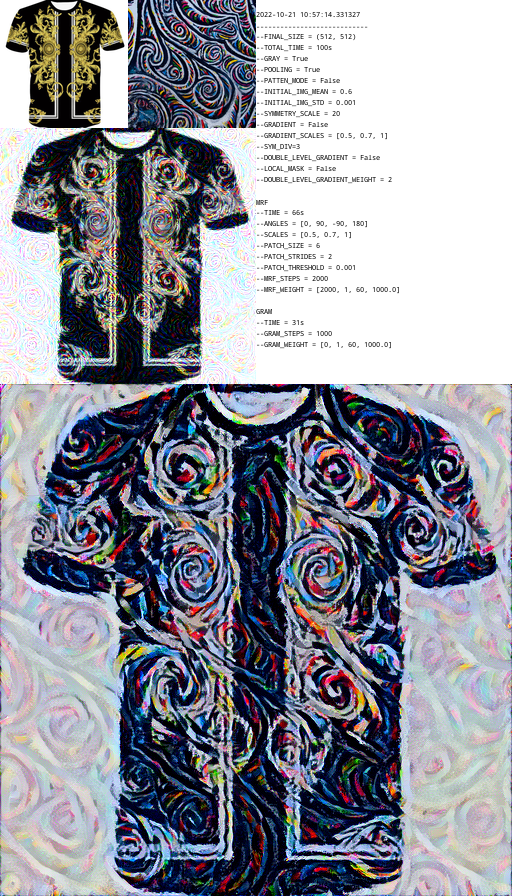

In [16]:
show(results, parameters)